In [113]:
import numpy as np
import matplotlib.pyplot as plt
import os

csv_path = "./ISING_1D/CSV/"
metr_path = csv_path + "Metr/"
gibbs_path = csv_path + "Gibbs/"
paths = [metr_path, gibbs_path]

plt.rcParams['figure.figsize'] = [8, 5]

points=100
T_th = np.linspace(0.2,2.5,num=points)
T = np.arange(0.5, 2 + 1 / 20, 1.5/20)

In [114]:
J = 1.0
Ns = 50

def U(T):

    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th

    return -J*( th + ch*thN )/( 1 + thN )

def C(T):

    beta = 1/T
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th

    return ((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

def X(T):

    beta = 1/T
    th = np.tanh(J/T)
    thN= th**Ns

    return beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

def M(T, h):

    b = 1/T
    l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    Z = l1**Ns + l2**Ns

    return (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

In [115]:
def LoadData(filename):
    data = []
    data_final = []

    for path in paths:
        
        suffix = ''
        if path == gibbs_path:
            suffix = '_g'

        data.append(np.flipud(np.loadtxt(path + filename + suffix, delimiter=',')))

    for sample_data in data:

        tmp_data = []
        for row in sample_data:
        
            if row[0] == 20:
    
                tmp_data.append([row[2], row[3]])

        data_final.append(tmp_data)

    return np.asarray(data_final)

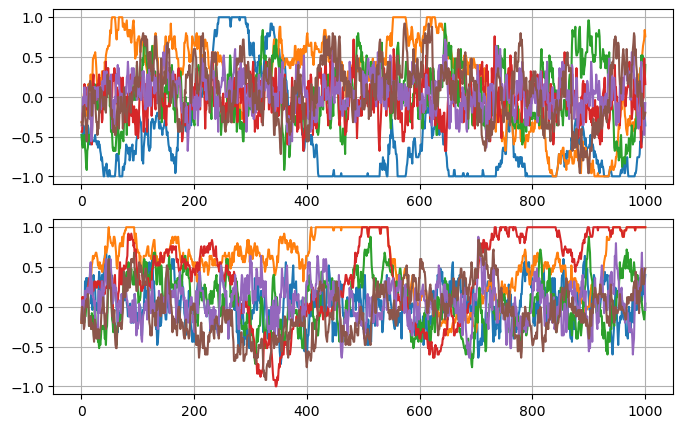

In [116]:
# TODO make this more comprehensible

eq_path = csv_path + "Eq/"

eq_path = csv_path + "Eq/"
eq_directories = [os.fsencode(eq_path + "Metr/"), os.fsencode(eq_path + "Gibbs/")]

for idx, directory in enumerate(eq_directories):

    plt.subplot(2, 1, idx + 1)
    plt.grid(True)

    for file in os.listdir(directory):

        filename = os.fsdecode(file)
        eq_data = np.loadtxt(os.fsdecode(directory) + filename, delimiter=',')

        plt.plot(eq_data[:, 0], eq_data[:, 1])

plt.show()

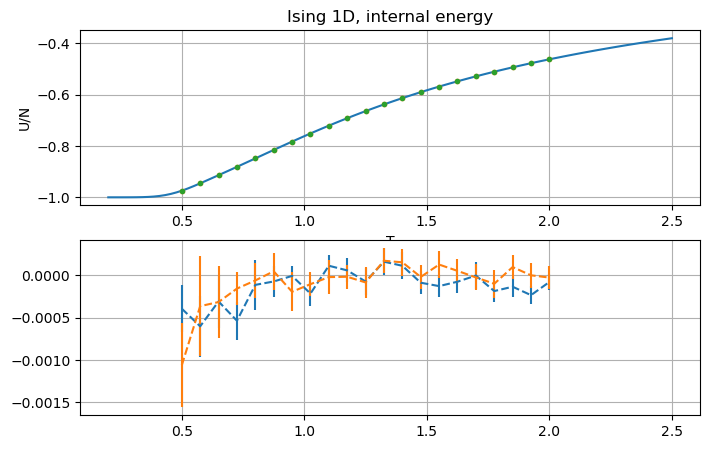

In [117]:
U_data_final = LoadData("output.ene.0")

ax1 = plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(T_th, U(T_th))
plt.title('Ising 1D, internal energy')
plt.xlabel('T')
plt.ylabel('U/N')
plt.errorbar(T, U_data_final[0][:, 0], yerr =  U_data_final[0][:, 1], fmt='.')
plt.errorbar(T, U_data_final[1][:, 0], yerr =  U_data_final[1][:, 1], fmt='.')

ax2 = plt.subplot(2, 1, 2, sharex = ax1)
plt.grid(True)
plt.errorbar(T, U_data_final[0][:,0] - U(T), yerr =  U_data_final[0][:, 1], linestyle = '--')
plt.errorbar(T, U_data_final[1][:,0] - U(T), yerr =  U_data_final[1][:, 1], linestyle = '--')
plt.show()

Note 10^4 steps per block yelded bad results for heat capacity

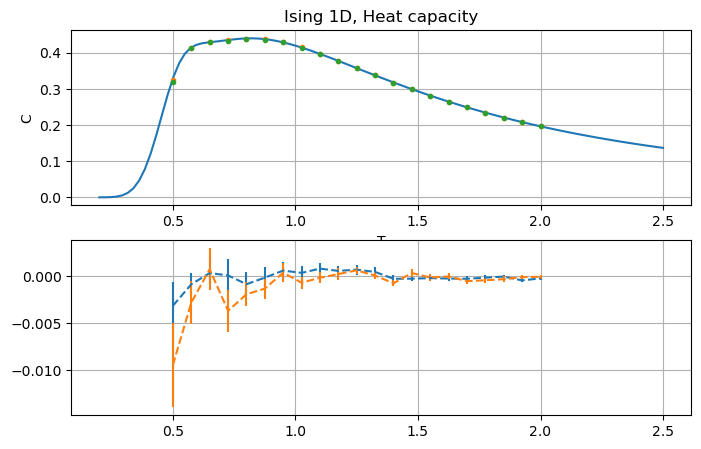

In [118]:
C_data_final = LoadData("output.hec.0")

ax1 = plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(T_th, C(T_th))
plt.title('Ising 1D, Heat capacity')
plt.xlabel('T')
plt.ylabel('C')
plt.errorbar(T, C_data_final[0][:, 0], yerr =  C_data_final[0][:, 1], fmt = '.')
plt.errorbar(T, C_data_final[1][:, 0], yerr =  C_data_final[1][:, 1], fmt = '.')

ax2 = plt.subplot(2, 1, 2, sharex = ax1)
plt.grid(True)
plt.errorbar(T, C_data_final[0][:,0] - C(T), yerr =  C_data_final[0][:, 1], linestyle = '--')
plt.errorbar(T, C_data_final[1][:,0] - C(T), yerr =  C_data_final[1][:, 1], linestyle = '--')
plt.grid(True)
plt.show()

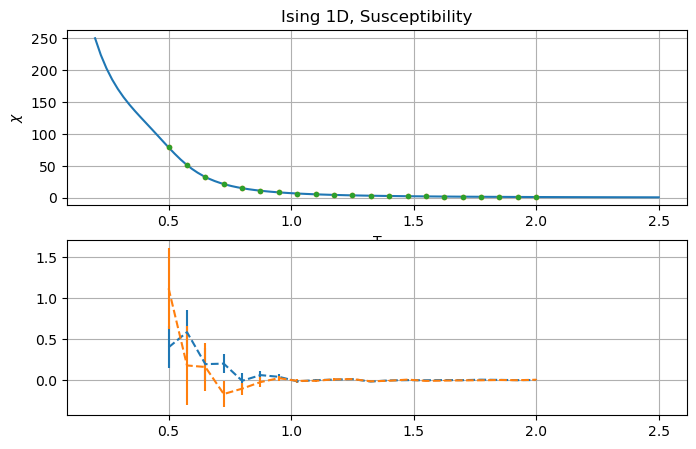

In [119]:
X_data_final = LoadData("output.chi.0")

ax1 = plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(T_th, X(T_th))
plt.title('Ising 1D, Susceptibility')
plt.xlabel('T')
plt.ylabel('$\chi$')
plt.errorbar(T, X_data_final[0][:, 0], yerr =  X_data_final[0][:, 1], fmt='.')
plt.errorbar(T, X_data_final[1][:, 0], yerr =  X_data_final[1][:, 1], fmt='.')

ax2 = plt.subplot(2, 1, 2, sharex = ax1)
plt.grid(True)
plt.errorbar(T, X_data_final[0][:,0] - X(T), yerr =  X_data_final[0][:, 1], linestyle = '--')
plt.errorbar(T, X_data_final[1][:,0] - X(T), yerr =  X_data_final[1][:, 1], linestyle = '--')
plt.grid(True)
plt.show()

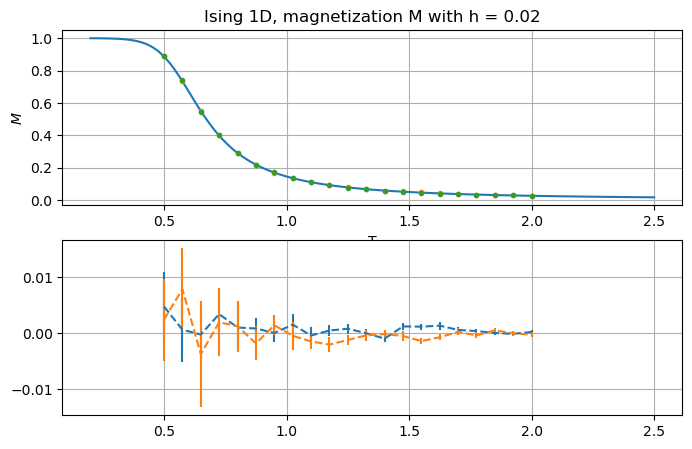

In [120]:
M_data_final = LoadData("output.mag.0.02")

h=0.02 #external field

ax1 = plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(T_th, M(T_th, h))
plt.title('Ising 1D, magnetization M with h = 0.02')
plt.xlabel('T')
plt.ylabel('$M$')
plt.errorbar(T, M_data_final[0][:, 0], yerr =  M_data_final[0][:, 1], fmt='.')
plt.errorbar(T, M_data_final[1][:, 0], yerr =  M_data_final[1][:, 1], fmt='.')

ax2 = plt.subplot(2, 1, 2, sharex = ax1)
plt.grid(True)
plt.errorbar(T, M_data_final[0][:,0] - M(T, h), yerr =  M_data_final[0][:, 1], linestyle = '--')
plt.errorbar(T, M_data_final[1][:,0] - M(T, h), yerr =  M_data_final[1][:, 1], linestyle = '--')
plt.grid(True)
plt.show()